# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>


In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read data files and remove irrelevant columns.

In [196]:
df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')

del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [197]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [198]:
df["article_id"] = df.article_id.astype('str')

In [199]:
df.dtypes

article_id    object
title         object
email         object
dtype: object

In [200]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` Distribution of how many articles a user interacts with in the dataset.  

In [201]:
df.email.value_counts().head()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: email, dtype: int64

In [202]:
df.email.value_counts().tail()

f5035acf16af3e79700393838fa1023ad38da668    1
81335c2e5917100a5cbdcc2bc0285fed6d685f6d    1
98d4864a24bc8f9915c8c8b5ebd3aa1eaa71cbaf    1
c87e297a1a99ae042be2015ff9056cf13195eefd    1
1f18e8aaccd6c8720180c3fe264c8aef5b00697f    1
Name: email, dtype: int64

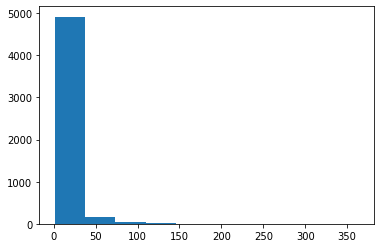

In [203]:
plt.hist(df.email.value_counts().values);

In [204]:
# median number of user article interactions
np.median(df.email.value_counts().values)

3.0

In [205]:
# The maximum number of user-article interactions by any one user
df.email.value_counts().max()

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [206]:
df_content.article_id.value_counts()

221     2
232     2
50      2
398     2
577     2
       ..
357     1
358     1
359     1
360     1
1050    1
Name: article_id, Length: 1051, dtype: int64

In [207]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [208]:
# The number of unique articles that have an interaction with a user.
df.article_id.nunique()

714

In [209]:
# The number of unique articles on the IBM platform
df_content.doc_full_name.nunique()

1051

In [210]:
# The number of unique users
df.email.nunique()

5148

In [211]:
# The number of user-article interactions
df.shape[0]

45993

`4.` Map users to a user id.

In [212]:
# The most viewed article in the dataset
# How many times was this article in the dataset viewed? 

df.article_id.value_counts().index[0], df.article_id.value_counts()[0]

('1429.0', 937)

In [213]:
def email_mapper():
    df_copy = df.copy()
    email_info = df_copy.email.unique()
    email_user_id_dict = dict(zip(email_info, range(1, len(email_info) + 1)))
    df_copy["user_id"] = df_copy.email.apply(lambda x: email_user_id_dict[x])
    df_copy.drop(["email"], inplace=True, axis=1)
    return df_copy

In [214]:
df = email_mapper()

In [215]:
df.shape

(45993, 3)

In [216]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [217]:
df.tail()

,article_id,title,user_id
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148
45992,16.0,higher-order logistic regression for large dat...,5149


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Return the **n** top articles ordered with most interactions as the top. 

In [221]:
df.title.value_counts().sort_values(ascending=False)[:5]

use deep learning for image classification                      937
insights from new york car accident reports                     927
visualize car data with brunel                                  671
use xgboost, scikit-learn & ibm watson machine learning apis    643
predicting churn with the spss random tree algorithm            627
Name: title, dtype: int64

In [222]:
def get_top_articles(n, df=df):
    """Returns top 'n' article titles ordered in descending order by most interactions

    :param n: The number of articles to return
    :type n: int
    :param df: Dataframe with data on users and articles, defaults to df
    :type df: pd.DataFrame, optional
    :return: A list of the top 'n' article titles
    :rtype: List[str]
    """
    top_articles = df.title.value_counts().sort_values(ascending=False)

    return list(top_articles.index[:n])

In [225]:
get_top_articles(5, df)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [266]:
def get_top_article_ids(n, df=df):
    """Returns top 'n' article ids ordered in descending order by most interactions

    :param n: The number of articles to return
    :type n: int
    :param df: Dataframe with data on users and articles, defaults to df
    :type df: pd.DataFrame, optional
    :return: A list of the top 'n' article ids
    :rtype: List[str]
    """
    top_articles = df.article_id.value_counts().sort_values(ascending=False)

    return list(top_articles.index[:n])

In [229]:
get_top_article_ids(5, df)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** appears in each **row** only once.
* Each **article** appears in each **column** only once.  


Any interaction between a user and article is coded as 1; no interaction is coded as 0.

In [230]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df=df):
    """Returns a dataframe with user ids as rows and articles ids as columns.
    Each cell may be 1 (interaction) or 0 (no interaction).

    :param df: Dataframe with data on users and articles, defaults to df
    :type df: pd.DataFrame, optional
    :return: Dataframe with user-article interactions
    :rtype: pd.DataFrame
    """
    num_users = df.iloc[:, 0].nunique()
    num_items = df.iloc[:, 1].nunique()
    users_keys = df.iloc[:, 0].unique()
    items_keys = df.iloc[:, 1].unique()

    user_item_mat = np.full((num_users, num_items), fill_value=0)

    user_id_lookup = dict(zip(users_keys, range(num_users)))
    item_id_lookup = dict(zip(items_keys, range(num_items)))

    for idx, row in df.iterrows():
        user_item_mat[user_id_lookup[row[0]], item_id_lookup[row[1]]] = 1

    user_item_df = pd.DataFrame(
        data=user_item_mat, index=users_keys, columns=items_keys
    )

    return user_item_df 

df = df[["user_id", "article_id", "title"]]
user_item = create_user_item_matrix(df)

In [231]:
user_item.shape

(5149, 714)

`2.` Given a user_id, find the most similar users - not including himself - ordered from the most similar users to the least similar users. Similarity is computed as the dot product of two users.


In [232]:
def _get_similar_users_ranked(user_id, user_item=user_item):
    """Helper function that finds users most similar to user_id and orders them
    from hight to low on similarity

    :param user_id: user_id
    :type user_id: int
    :param user_item: A dataframe with users as rows and articles as columns; each cell
    is a 1 (interaction) or 0 (no interaction), defaults to user_item
    :type user_item: pd.DataFrame, optional
    :return: Tuple of similarity scores and corresponding rank ordered indices of 
    scores from high to low
    :rtype: List[np.ndarray, np.ndarray]
    """
    similarity_scores_user_id = np.dot(
        user_item.loc[user_id, :], np.transpose(user_item)
    )
    ranked_users_idx = np.argsort(similarity_scores_user_id)[::-1]
    delete_self_idx = np.where(user_item.index == user_id)[0][0]
    ranked_users_idx = np.delete(
        ranked_users_idx, np.where(ranked_users_idx == delete_self_idx)
    )

    return similarity_scores_user_id, ranked_users_idx


def find_similar_users(user_id, user_item=user_item):
    """Finds the users most similar to a given user.

    :param user_id: user_id
    :type user_id: int
    :param user_item: A dataframe with users as rows and articles as columns; each cell
    is a 1 (interaction) or 0 (no interaction), defaults to user_item
    :type user_item: pd.DataFrame, optional
    :return: List of article ids of most similar users ordered by similarity
    :rtype: List[int]
    """
    _, ranked_users_idx = _get_similar_users_ranked(user_id, user_item)
    most_similar_users = user_item.index[ranked_users_idx]

    return most_similar_users

In [235]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1, user_item)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933, user_item)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46, user_item)[:3]))

The 10 most similar users to user 1 are: Int64Index([3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041], dtype='int64')
The 5 most similar users to user 3933 are: Int64Index([1, 23, 3782, 4459, 203], dtype='int64')
The 3 most similar users to user 46 are: Int64Index([4201, 23, 3782], dtype='int64')


`3.` The functions below are used to return the articles you would recommend to each user. 

In [246]:
def get_article_names(article_ids, df=df):
    """Get list of article names associated with list of article ids

    :param article_ids: List of article ids
    :type article_ids: List[str]
    :param df: Dataframe with data on users and articles, defaults to df
    :type df: pd.DataFrame, optional
    :return: List of article names associated with article ids
    :rtype: List[str]
    """
    df_copy = df.copy()
    df_copy.set_index(["article_id"], inplace=True)
    article_names = df_copy.title[article_ids].unique().tolist()

    return article_names

In [247]:
article_ids = ['1430.0', '1314.0']
get_article_names(article_ids)

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'healthcare python streaming application demo']

In [248]:
def get_user_articles(user_id, user_item=user_item):
    """Finds the ids and associated titles of articles that a given user has viewed.

    :param user_id: user id
    :type user_id: int
    :param user_item: A dataframe with users as rows and articles as columns; each cell
    is a 1 (interaction) or 0 (no interaction), defaults to user_item
    :type user_item: pd.DataFrame, optional
    :return: Tuple of lists of article ids and corresponding article titles
    :rtype: Tuple[List[str], List[str]]
    """
    df1 = df.copy()
    df1.set_index(["user_id"], inplace=True)
    article_ids = df1.article_id[user_id]
    article_names = df1.title[user_id]

    # If a user has interacted with only one article, then the article_ids variable
    # will be a string value not a series.
    if not isinstance(article_ids, (str)):
        article_ids = list(set(article_ids))
        article_names = list(set(article_names))
    else:
        article_ids = [article_ids]
        article_names = [article_names]

    return article_ids, article_names

In [249]:
ai, an = get_user_articles(1, user_item)

In [250]:
ai[:5], an[:5]

(['1439.0', '109.0', '1368.0', '585.0', '981.0'],
 ['shiny 0.13.0',
  'tidyverse practice: mapping large european cities',
  'welcome to pixiedust',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation'])

In [251]:
def user_user_recs(user_id, user_item=user_item, m=10):
    """Find m recommendations for a given user. Starting with the user most similar to user_id,
    finds articles not seen by user_id until m recommendations are found. If users are
    equally close then a user is chosen arbitrarily. If a given user returns fewer than m
    recommendations, then the remaining ones are added arbitrarily.

    :param user_id: user_id
    :type user_id: int
    :param user_item: A dataframe with users as rows and articles as columns; each cell
    is a 1 (interaction) or 0 (no interaction), defaults to user_item
    :type user_item: pd.DataFrame, optional
    :param m: Number of recommendations desired, defaults to 10
    :type m: int, optional
    :return: List of m recommendations - article ids - for the user
    :rtype: List[int]
    """
    recs_set = set()

    articles_seen_user_id, _ = get_user_articles(user_id, user_item)
    similar_users = find_similar_users(user_id, user_item)

    for user in similar_users:
        article_ids, _ = get_user_articles(user, user_item)
        article_ids = np.setdiff1d(article_ids, articles_seen_user_id)
        recs_set.update(article_ids)
        recs = list(recs_set)
        if len(recs_set) >= m:
            recs = recs[:m]
            break

    return recs

In [256]:
get_article_names(user_user_recs(20, user_item, m=10), df)

['tensorflow quick tips',
 'putting a human face on machine learning',
 'building custom machine learning algorithms with apache systemml',
 'classify tumors with machine learning',
 'model bike sharing data with spss',
 'overlapping co-cluster recommendation algorithm (ocular)',
 'using deep learning with keras to predict customer churn',
 'visualize the 1854 london cholera outbreak',
 'apache spark lab, part 3: machine learning',
 'modeling energy usage in new york city']

`4.` Improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking is obtained from the **get_top_sorted_users** function.

In [260]:
def get_top_sorted_users(user_id, user_item=user_item, df=df):
    """Calculates the similarity of users (neighbors) to the requested user along with the
    number of articles viewed. The neighbors are sorted in descending order of similarity and
    number of articles viewed such that closest neighbors appear at the top. In cases where 
    neighbors are equally close, those with more articles viewed appear first.

    :param user_id: user id
    :type user_id: int
    :param df: Dataframe with data on users and articles, defaults to df
    :type df: pd.DataFrame, optional
    :param user_item: A dataframe with users as rows and articles as columns; each cell
    is a 1 (interaction) or 0 (no interaction), defaults to user_item
    :type user_item: pd.DataFrame, optional
    :return: A dataframe with neighbors of user_id sorted first by similarity and then by the 
    number of articles viewed by the neighbor in descending order
    :rtype: pd.DataFrame
    """
    similarity_scores_user_id, ranked_users_idx = _get_similar_users_ranked(
        user_id, user_item
    )
    ranked_similarities = similarity_scores_user_id[ranked_users_idx]
    ranked_users = user_item.index[ranked_users_idx]
    user_interactions = df.user_id.value_counts()
    user_interactions.drop(labels=[user_id], inplace=True)

    cols = ["neighbor_id", "similarity", "num_interactions"]
    data = [ranked_users, ranked_similarities, user_interactions]
    neighbors_df = pd.DataFrame.from_dict(dict(zip(cols, data)))
    neighbors_df.sort_values(
        by=["similarity", "num_interactions"], ascending=[False, False], inplace=True
    )

    return neighbors_df


In [261]:
def user_user_recs_part2(user_id, user_item=user_item, df=df, m=10):
    """Find m recommendations for a given user. Starting with the closest user to user_id,
    finds articles not seen by user_id until m recommendations are found. If users are
    equally close then users are chosen in descending order of the number of interactions. 
    Articles are added based on the descending order of total article interactions.

    :param user_id: user_id
    :type user_id: int
    :param user_item: A dataframe with users as rows and articles as columns; each cell
    is a 1 (interaction) or 0 (no interaction), defaults to user_item
    :type user_item: pd.DataFrame, optional
    :param m: Number of recommendations desired, defaults to 10
    :type m: int, optional
    :return: Tuple with lists of article ids and corresponding article titles - the lists are
    of size m
    :rtype: Tuple[List[str], List[str]]
    """
    recs_set = set()

    articles_seen_user_id, _ = get_user_articles(user_id, user_item)
    similar_users = get_top_sorted_users(user_id, user_item, df)["neighbor_id"].values

    article_interactions = df.article_id.value_counts()

    for user in similar_users:
        article_ids, _ = get_user_articles(user, user_item)
        article_ids = np.setdiff1d(article_ids, articles_seen_user_id)
        user_interactions = article_interactions[article_ids]
        user_interactions_ranked = user_interactions.sort_values(ascending=False)

        recs_set.update(user_interactions_ranked)
        recs_ids = list(recs_set)
        if len(recs_set) >= m:
            recs_ids = recs_ids[:m]
            break
    recs_names = get_article_names(recs_ids, df)

    return recs_ids, recs_names

In [264]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[512, 643, 135, 14, 15, 18, 20, 279, 24, 28]

The top 10 recommendations for user 20 are the following article names:
['tensorflow quick tips', 'ml optimization using cognitive assistant', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'apache spark lab, part 1: basic concepts', 'getting started with python', 'healthcare python streaming application demo', 'visualize data with the matplotlib library', 'dsx: hybrid mode']


`5.` The top 10 recommended articles one would provide for the a new user.

In [269]:
new_user = '0.0'
new_user_recs = get_article_names(get_top_article_ids(10))
new_user_recs

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

Use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We split our dataset into a training and test set of data and then calculate accuracy on them for different numbers of latent features


In [270]:
def create_test_and_train_user_item(df=df, train_size=40000):
    """Creates a matrix of users and items for the training and test data where each
    user is a row and each article is a column. A cell with value of 1 represents an interaction
    while 0 represents an absence of one.

    :param df: Data set with , defaults to df
    :type df: pd.DataFrame, optional
    :param train_size: Size of the training set, defaults to 40000
    :type train_size: int, optional
    :return: A tuple consisting of user-item dataframes for the training and test data, the user ids
    for the test data, and the article ids for the test data
    :rtype: Tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]
    """

    df_train = df.head(train_size)
    df_test = df.tail(df.shape[0] - train_size)

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    test_user_ids = df_test.user_id.unique()
    test_article_ids = df_test.article_id.unique()

    return user_item_train, user_item_test, test_user_ids, test_article_ids

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df)

`2.` We use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then we find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features in order to see how many features it makes sense to keep based on the accuracy on the test data. 

In [271]:
def evaluate_accuracy(num_latent_features, df, train_size=40000):
    """Estimate the mean error in the train and test sets where error is the difference 
    between the actual value and the predicted value for a given number of latent features. 
    Calculate accuracy for train and test set

    :param num_latent_features: A vector with a range of values for the number of features to 
    use to generate the predictions matrix. The maximum is the number of columns in the user
    item matrix
    :type num_latent_features: np.ndarray
    :param train_size: Size of the training set, defaults to 40000
    :type train_size: int, optional
    :return: a tuple with list of accuracy values for the train set and the test set
    :rtype: Tuple[List[float], List[float]]
    """

    (
        user_item_train,
        user_item_test,
        test_user_ids,
        test_article_ids,
    ) = create_test_and_train_user_item(df, train_size=train_size)

    train_user_ids = user_item_train.index
    train_article_ids = user_item_train.columns

    users_in_common = train_user_ids.intersection(test_user_ids)
    articles_in_common = train_article_ids.intersection(test_article_ids)

    test_users_idx = np.where(train_user_ids.isin(users_in_common))[0]
    test_articles_idx = np.where(train_article_ids.isin(articles_in_common))[0]

    errors_train_k, errors_test_k = [], []
    u, s, vt = np.linalg.svd(user_item_train)

    for k in num_latent_features:
        s_train, u_train, vt_train = (
            np.diag(s[:k]),
            u[:, :k],
            vt[:k, :],
        )

        s_test = s_train
        u_test = u_train[test_users_idx, :k]
        vt_test = vt_train[:k, test_articles_idx]

        user_item_train_est = np.around(np.dot(np.dot(u_train, s_train), vt_train))
        user_item_train_act = user_item_train.values

        user_item_test_est = np.around(np.dot(np.dot(u_test, s_test), vt_test))
        user_item_test_act = user_item_test.loc[
            users_in_common, test_article_ids
        ].values

        train_errors = np.subtract(user_item_train_act, user_item_train_est)
        test_errors = np.subtract(user_item_test_act, user_item_test_est)

        sum_errors_train = np.sum(np.abs(train_errors))
        sum_errors_test = np.sum(np.abs(test_errors))

        errors_train_k.append(sum_errors_train)
        errors_test_k.append(sum_errors_test)

    mean_errors_train_k = np.array(errors_train_k) / (
        user_item_train_act.shape[0] * user_item_train_act.shape[1]
    )
    mean_errors_test_k = np.array(errors_test_k) / (
        user_item_test_act.shape[0] * user_item_test_act.shape[1]
    )

    accuracy_train_k = 1 - mean_errors_train_k
    accuracy_test_k = 1 - mean_errors_test_k

    return accuracy_train_k, accuracy_test_k


In [272]:
num_latent_features = np.arange(10, 720, 10)
accuracy_train_k, accuracy_test_k = evaluate_accuracy(num_latent_features, df)

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

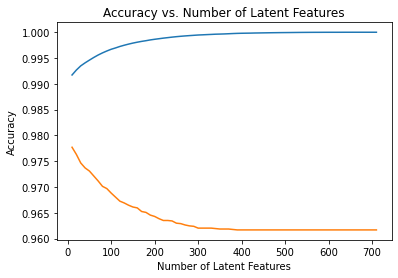

In [273]:
plt.plot(num_latent_features, accuracy_train_k)
plt.plot(num_latent_features, accuracy_test_k)
plt.xlabel("Number of Latent Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Latent Features")

Test performance worsens with the addition of more latent features due to overfitting. There are only 20 users in the training set that are also present in the test set. One way to improve performance would be to have greater coverage of users in the training set. With the current data, choosing a smaller number of latent features would give better performance.

The data is highly imbalanced: only 0.916% of the training data and 1.135% are classified as a 1. One may report a high accuracy simply by always predicting zero. Here we are interested in letting users discover resources and consequently, may be less concerned about false positives. Hence, recall may be a more useful metric. To address imbalance, one may try weighting the errors based on class frequency or a sampling method such as SMOTE.

Rank-based recommenders are useful because they address the cold-start problem. With collaborative filtering, we can use information on interactions of users with articles to give recommendations that are more relevant. But these may suffer from problems such as lack of novelty or serendipity. As such a blended recommendation system might serve the needs of users better.

One may test a blended recommendation system against the current one using A/B testing. Users may be randomly assigned to two groups with the treatment group being exposed to the new system. One could perform a statistical test for the difference in number of interactions between the two groups. Depending on business concerns, one would also have to think of practical significance even if there is a statistical significant improvement from using the blended system.